## Embracing the gradient: A brief tour of Bayes Factor implementation 

 >"I have approximate answers and possible beliefs and different degrees of uncertainty about different things, but I am not absolutely sure of anything [...]" - Richard Feynman 

In this lab, we will learn to use the [BayesFactor](https://cran.r-project.org/web/packages/BayesFactor/BayesFactor.pdf) library. Using the tools from this library, we will quantify the *amount* of evidence for alternative hypotheses instead of fully supporting or fully rejecting them altogether. 

##  What is a Bayes factor? 
  * The Bayes factor is the analytical response to the question: What is the strength of the evidence for my model, given a competing hypothesis? If you're interested in the *relative* weight of evidence for competing hypotheses, then the Bayes Factor is for you. 
  * The Bayes factor is a ratio of the evidence for one model over another. It can be expressed as the relative likelihood of the data given a set of hypotheses: 
  
  $$BF = \frac{P(D|H_1)}{P(D|H_0)}$$
  
* Similar to the Bayesian Information Criterion (BIC), the Bayes factor penalizes model complexity. 
  <br>
  <br>
Look [here](http://statmath.wu.ac.at/research/talks/resources/talkheld.pdf) and [here](https://link.springer.com/article/10.3758/s13423-017-1262-3) for a more in-depth treatment. This tutorial is based largely on [Richard Morey's introduction to the package](https://richarddmorey.github.io/BayesFactor/#help). 

---
# Implementing the Bayes factor with a simple example

In [3]:
# install.packages('BayesFactor') #install 

also installing the dependencies ‘elliptic’, ‘contfrac’, ‘deSolve’, ‘pbapply’, ‘hypergeo’




The downloaded binary packages are in
	/var/folders/p1/jq19by4n7gd9qnhl3cywmknr0000gn/T//RtmpPVvA6l/downloaded_packages


In [7]:
library(ISLR)
library(BayesFactor)

In [14]:
#you can see that there are functions to calculate BF for many different tests, including correlations, linear regresssion, and t-tests
lsf.str("package:BayesFactor") # a list of all of the functions in the package

anovaBF : function (formula, data, whichRandom = NULL, whichModels = "withmain", 
    iterations = 10000, progress = getOption("BFprogress", interactive()), 
    rscaleFixed = "medium", rscaleRandom = "nuisance", rscaleEffects = NULL, 
    multicore = FALSE, method = "auto", noSample = FALSE, callback = function(...) as.integer(0))  
as.BFBayesFactor : function (object)  
as.BFprobability : function (object, normalize = NULL, lognormalize = NULL)  
BFInfo : function (print = TRUE)  
BFManual : function ()  
compare : Formal class 'standardGeneric' [package "methods"] with 8 slots
contingencyTableBF : function (x, sampleType, fixedMargin = NULL, priorConcentration = 1, posterior = FALSE, 
    callback = function(...) as.integer(0), ...)  
correlationBF : function (y, x, rscale = "medium", nullInterval = NULL, posterior = FALSE, 
    callback = function(...) as.integer(0), ...)  
enumerateGeneralModels : function (fmla, whichModels, neverExclude = NULL, includeBottom = TRUE, 
    data = 

Let's start with the a simple example. We'll use the `sleep` dataset included in R to calculate the evidence for the null hypothesis that there is no effect of sleep deprivation on reaction time. 

In [15]:
data(sleep) #Remember, this is a within-subjects design measuring the impact of sleep dep. on RTs

## Compute difference scores
diffScores = sleep$extra[1:10] - sleep$extra[11:20] #subtracting the scores in one condition from the other 
#extra is the numeric increase (or decrease) in the amount of sleep gotten, in hours

## Traditional one-sample t-test 
t.test(diffScores) 


	One Sample t-test

data:  diffScores
t = -4.0621, df = 9, p-value = 0.002833
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -2.4598858 -0.7001142
sample estimates:
mean of x 
    -1.58 


In [42]:
bf = ttestBF(x = sleep$extra[1:10],y=sleep$extra[11:20], paired=TRUE) #this is the BF object 
bf #the relative evidence for the alternative hypothesis (nonzero difference between conditions)

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 17.25888 ±0%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


Note the denominator specification in the output! Make sure to interpret these correctly. Here, the denominator is the null hypothesis, so this is the relative evidence for the alternative hypothesis, that the difference in sleep gotten between conditions is non-zero. 

In [44]:
1/bf #the relative evidence for the null hypothesis (no difference between conditions)

Bayes factor analysis
--------------
[1] Null, mu=0 : 0.05794119 ±0%

Against denominator:
  Alternative, r = 0.707106781186548, mu =/= 0 
---
Bayes factor type: BFoneSample, JZS


To test a directional hypothesis, you can set the `nullInterval` argument to the range of interest. Here, we will compute the weight of evidence for the alternative hypothesis that the difference in the amount of sleep gotten between conditions will be negative. 

In [45]:
#we can also test a directional hypothesis  
bfInterval = ttestBF(x = diffScores, nullInterval=c(-Inf,0)) #here we test the hypothesis that the difference is less than 0
bfInterval

Bayes factor analysis
--------------
[1] Alt., r=0.707 -Inf<d<0    : 34.41694  ±0%
[2] Alt., r=0.707 !(-Inf<d<0) : 0.1008246 ±0.06%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


Here you can see the evidence for both possible situations evalauated against the null as the denominator. Line 1 shows the evidence that the difference between conditions is negative, and line 2 shows the evidence tha the difference between conditions is  non-negative (positive). 

Now what if you were interested in directly comparing the evidence for a negative difference with the evidence for a positive difference? You can directly manipulate the Bayes Factor object to achieve this. Since both of these evidence ratios have the same denominator, we can directly compare these results like this: 

In [50]:
bfNegative = bfInterval[1] / bfInterval[2] #here we compare the evidence for a negative difference against the evidence for a positive one

bfNegative
#note the denominator specification

Bayes factor analysis
--------------
[1] Alt., r=0.707 -Inf<d<0 : 341.3547 ±0.06%

Against denominator:
  Alternative, r = 0.707106781186548, mu =/= 0 !(-Inf<d<0) 
---
Bayes factor type: BFoneSample, JZS


And like before, we can take the invert this ratio to find the evidence for a positive difference against the evidence for a negative one: 

In [52]:
bfPositive = 1 / bfNegative #as you might expect, the evidence for a positive difference is miniscule 
bfPositive

Bayes factor analysis
--------------
[1] Alt., r=0.707 !(-Inf<d<0) : 0.002929504 ±0.06%

Against denominator:
  Alternative, r = 0.707106781186548, mu =/= 0 -Inf<d<0 
---
Bayes factor type: BFoneSample, JZS


You can use the `plot` function in the `BayesFactor` package to visually evaluate the difference in the relative evidence for each of these hypotheses.

In [53]:
bf #let's gather the three hypotheses we evaluated that have the same (null, zero-difference) denominator

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 17.25888 ±0%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


In [55]:
allbf = c(bf, bfInterval)

allbf

Bayes factor analysis
--------------
[1] Alt., r=0.707             : 17.25888  ±0%
[2] Alt., r=0.707 -Inf<d<0    : 34.41694  ±0%
[3] Alt., r=0.707 !(-Inf<d<0) : 0.1008246 ±0.06%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


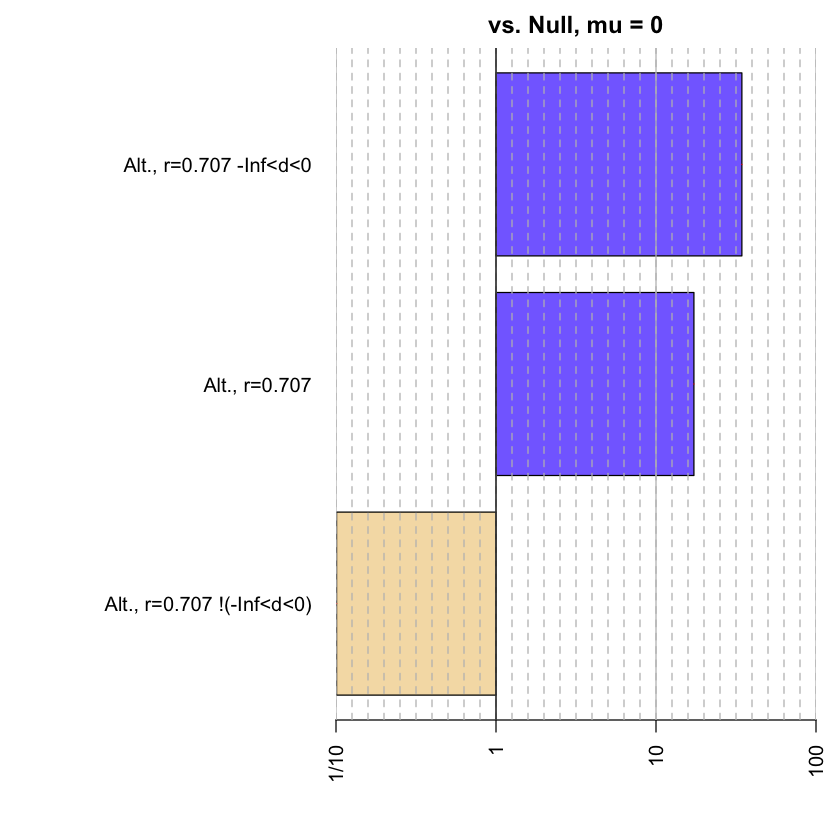

In [56]:
plot(allbf)

# Calculating the Bayes Factor for comparison of candidate mixed effect models

Now let's see how to apply this to hierarchical linear regression.

In [60]:
data(ToothGrowth)

# model log10 of dose instead of dose directly
ToothGrowth$dose = log10(ToothGrowth$dose)

# Classic analysis for comparison
lmToothGrowth <- lm(len ~ supp + dose + supp:dose, data=ToothGrowth)
summary(lmToothGrowth)


Call:
lm(formula = len ~ supp + dose + supp:dose, data = ToothGrowth)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5433 -2.4921 -0.5033  2.7117  7.8567 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  20.6633     0.6791  30.425  < 2e-16 ***
suppVC       -3.7000     0.9605  -3.852 0.000303 ***
dose         21.3102     2.7631   7.712  2.3e-10 ***
suppVC:dose   8.8529     3.9076   2.266 0.027366 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.72 on 56 degrees of freedom
Multiple R-squared:  0.7755,	Adjusted R-squared:  0.7635 
F-statistic:  64.5 on 3 and 56 DF,  p-value: < 2.2e-16


The classic analysis shows low p-values for the effects of supplement type and dose on tooth growth with an interaction effect. We can use the lmBF function to calculate the Bayes factors for all models of interest against a null intercept-only model. 

In [62]:
full <- lmBF(len ~ supp + dose + supp:dose, data=ToothGrowth) #all predictors + interaction
noInteraction <- lmBF(len ~ supp + dose, data=ToothGrowth) #no interaction
onlyDose <- lmBF(len ~ dose, data=ToothGrowth) #only dose
onlySupp <- lmBF(len ~ supp, data=ToothGrowth) #only supplementation

allBFs <- c(full, noInteraction, onlyDose, onlySupp)
allBFs

Bayes factor analysis
--------------
[1] supp + dose + supp:dose : 1.568821e+15 ±0.62%
[2] supp + dose             : 1.524445e+15 ±1.43%
[3] dose                    : 2.769593e+13 ±0.01%
[4] supp                    : 1.198757     ±0.01%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS


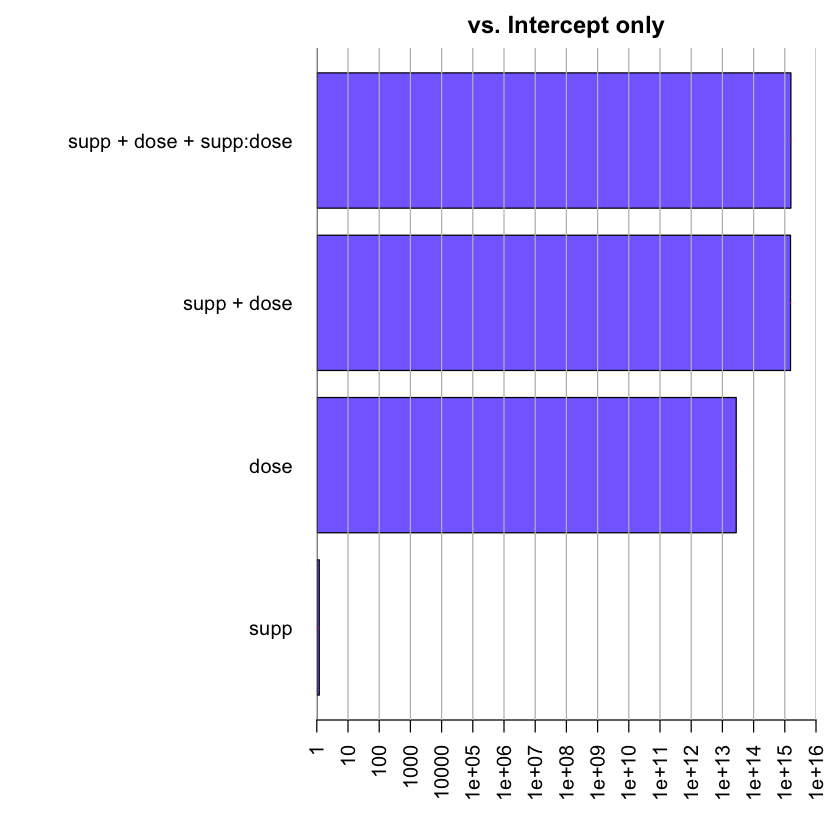

In [63]:
plot(allBFs)

The results from the interaction model and the no-interaction model are close. Let's directly evaluate these two hypotheses against one another.

In [64]:
full / noInteraction

Bayes factor analysis
--------------
[1] supp + dose + supp:dose : 1.02911 ±1.56%

Against denominator:
  len ~ supp + dose 
---
Bayes factor type: BFlinearModel, JZS


Even after direct comparison, there's no clear difference between the two models. 

# Problem set

1) Using a built-in dataset, come up with a few viable alternative models and compute the BF for and against a null model. 
<br>
2) Calculate the BF for and against a linear correlation between two variables.
<br>
3) Calculate the weight of evidence for a directional hypothesis using a Bayesian two-sample t-test. 

More on how to use the BayesFactor package [here](https://richarddmorey.github.io/BayesFactor/#help). 